Prompt chaining is a technique in NLP where multiple prompts r sequenced together to guide a model through a complex task or reasoning process.

Instead of reying on single prompt to achieve a desired outcome, prompt chaining breaks the task into smaller, manageable steps, with each step building on the previous one.

This approach can improve accuracy, coherence, and control when working with llm's.

# How prompt chaining works in langgraph

1. Define the task: start by breaking down the problem into smaller sub-tasks. For example, if u want to generate a detailed report, u might split it into steps like "gather data", "analyze data", "write summary".

2. create Nodes: each sub-task becomes a node in the Langgraph structure. A node can be prompt that instructs the model to perform a specific action, such as "List key facts about X" or "Summarize the following text".

3. Establish Edges: 

4. Execute the graph:

5. Iterate if needed:

In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

from langchain_openai import ChatOpenAI

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

result = llm.invoke("What is the capital of France?")

result.content

'The capital of France is Paris.'

In [2]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# GRAPH STATE
class State(TypedDict):
    topic: str
    story: str
    improved_story: str # by improved node
    final_story: str # by polish node

In [3]:
def generate_story(state: State) :
    msg = llm.invoke(f"write a one sentence story about {state['topic']}")
    return {"story": msg.content}

def check_story(state: State) :
    if "?" in state["story"] or "!" in state["story"] :
        return "Fail"
    return "Pass"

def improved_story(state: State) :
    msg = llm.invoke(f"enhance the following story: {state['story']}")
    return {"improved_story": msg.content}

def polish_story(state: State) :
    msg = llm.invoke(f"polish the following story by adding a twist: {state['improved_story']}")
    return {"final_story": msg.content}



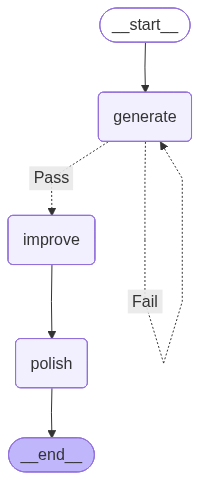

In [6]:
## Build the graph
graph = StateGraph(State)

graph.add_node("generate", generate_story)
graph.add_node("improve", improved_story)
graph.add_node("polish", polish_story)

# define the edges
graph.add_edge(START, "generate")
graph.add_conditional_edges("generate", check_story, {"Fail": "generate", "Pass": "improve"})

graph.add_edge("improve", "polish")
graph.add_edge("polish", END)

# compile the graph
compiled_graph = graph.compile()
#display the graph
display(Image(compiled_graph.get_graph().draw_mermaid_png()))


In [8]:
## Run the graph
state = {"topic": "Quantum Computing"}

result = compiled_graph.invoke(state)

result

{'topic': 'Quantum Computing',
 'story': 'In a world where quantum computers unlocked the secrets of the universe, a young scientist discovered a way to communicate with alternate realities, forever altering the fabric of existence.',
 'improved_story': 'In a world where quantum computers had transcended the boundaries of human understanding, unlocking the secrets of the universe with their unfathomable processing power, a young scientist named Elara Voss stood on the precipice of a groundbreaking discovery. The year was 2045, and the Quantum Nexus, a colossal facility dedicated to the exploration of quantum mechanics, buzzed with the energy of innovation and ambition. \n\nElara, a prodigy with a mind as sharp as the algorithms she crafted, had always been fascinated by the concept of parallel universes. As a child, she would gaze at the stars, dreaming of worlds where different choices led to different lives. Her relentless curiosity drove her to push the boundaries of quantum theory,

In [9]:
print("Improved story: ", result["improved_story"])
print("Final story: ", result["final_story"])

Improved story:  In a world where quantum computers had transcended the boundaries of human understanding, unlocking the secrets of the universe with their unfathomable processing power, a young scientist named Elara Voss stood on the precipice of a groundbreaking discovery. The year was 2045, and the Quantum Nexus, a colossal facility dedicated to the exploration of quantum mechanics, buzzed with the energy of innovation and ambition. 

Elara, a prodigy with a mind as sharp as the algorithms she crafted, had always been fascinated by the concept of parallel universes. As a child, she would gaze at the stars, dreaming of worlds where different choices led to different lives. Her relentless curiosity drove her to push the boundaries of quantum theory, and after years of tireless research, she stumbled upon a revolutionary breakthrough: a method to communicate with alternate realities.

Using a sophisticated quantum entanglement device she dubbed the "Reality Resonator," Elara initiated 